In [43]:
# Importing the necessary libraries

import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = ""
# import tensorflow_datasets as tfds
from tensorflow.train import Checkpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.initializers import RandomNormal

In [44]:
# Change Your Dataset Path Here
test_mr  = tf.data.Dataset.list_files(str('../Dataset/Rebuild/mr234/*'), shuffle=True)
test_ct  = tf.data.Dataset.list_files(str('../Dataset/Rebuild/ct234/*'), shuffle=True)

train_mr = tf.data.Dataset.list_files(str('../Dataset/CHAOS/Train_Sets/MR/*'), shuffle=True)
train_ct = tf.data.Dataset.list_files(str('../Dataset/CHAOS/Train_Sets/CT/*'), shuffle=True)
def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = parts[-2]

  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [256, 256])
  return image, label

test_mr = test_mr.map(parse_image)
test_ct = test_ct.map(parse_image)
train_mr = train_mr.map(parse_image)
train_ct = train_ct.map(parse_image)

In [45]:
# Declaring the constants
AUTOTUNE = tf.data.experimental.AUTOTUNE

# used to prevent identity loss i.e. loss in the color of picture when transforming
LAMBDA = 10

# number of iteration to perform the training 
EPOCHS = 30000

# used to shuffle 1000 images
BUFFER_SIZE = 1000

# declaring batches to train on a number of specified images simultaneously
BATCH_SIZE = 20

# image dimensions
IMG_WIDTH = 256
IMG_HEIGHT = 256
CHANNELS = 3

# setting random normalized weights 
weight_initializer = RandomNormal(stddev=0.02)

# the loss function used here is BinaryCrossentropy as we have to classify whether the generated image matches the original or not
loss = BinaryCrossentropy(from_logits=True)

# the optimizers are set to Adam with learning_rate as 2e-4 and beta_1 as 0.5
gen_g_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
gen_f_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
disc_x_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-6, beta_1=0.5)
disc_y_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-6, beta_1=0.5)

In [46]:
# to crop the image to our desired dimensions
def random_crop(image):
    image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, CHANNELS])
    return image

In [47]:
# to normalize the image to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    # image = (image / 127.5) - 1
    return image

In [48]:
# generating images with random properties such as fliping the image on vertical axis
def random_jitter(image):
    image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = random_crop(image)
    image = tf.image.random_flip_left_right(image)
    return image

In [49]:
# method to preprocess the train images
def preprocess_train_image(image, label):
    image = random_jitter(image)
    image = normalize(image)
    return image

In [50]:
train_mr = train_mr.map(preprocess_train_image, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_ct = train_ct.map(preprocess_train_image, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [51]:
class InstanceNormalization(tf.keras.layers.Layer):

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

In [52]:
# “conv4x4 denotes a 4 × 4 Convolution-InstanceNorm-LeakyReLU layer with k filters and stride 2"

def conv4x4(inputs, k, kernel_size=(4,4), use_instancenorm=True):
    block = Conv2D(k, kernel_size, strides=2, padding='same', kernel_initializer=weight_initializer)(inputs)
    if use_instancenorm:
        block = InstanceNormalization()(block)
    block = LeakyReLU(0.2)(block)
    return block

In [53]:
# Method to create discriminator with the architecture mentioned in original paper (C64, C128, C256, C512)
def discriminator():

    # declaring the shape of input image (here is it 256x256x3)
    dis_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
    
    # creating the arch
    d = conv4x4(dis_input, 64, use_instancenorm=False)
    d = conv4x4(d, 128)
    d = conv4x4(d, 256)
    d = conv4x4(d, 512)

    # layer to classify between the originality of generated images
    d = Conv2D(1, kernel_size=(4,4), kernel_initializer=weight_initializer, padding='same')(d)

    # generating a model using inputs and outputs
    dis = Model(dis_input, d)

    # compiling the model as it would be used to classify the images
    dis.compile(loss='mse', optimizer=disc_x_optimizer)
    return dis

    # can change the loss function to binarycrossentropy and adding a Fully connected network as ouput layer (have to experiment)

In [54]:
# "downconv3x3 denotes a 3×3 Convolution-InstanceNorm-ReLU with k filters and stride 2"
def downconv3x3(inputs, k, kernel_size=(3,3)):
    block = Conv2D(k, kernel_size, strides=2, padding='same', kernel_initializer=weight_initializer)(inputs)
    block = InstanceNormalization()(block)
    block = Activation(tf.nn.relu)(block)
    return block

In [55]:
# "residualconv3x3 denotes a residual block that contains two 3×3 convolutional layers with k filters on each layer"
def residualconv3x3(inputs, k, kernel_size=(3,3)):
    block = Conv2D(k, kernel_size, strides=1, padding='same', kernel_initializer=weight_initializer)(inputs)
    block = InstanceNormalization()(block)
    block = Activation(tf.nn.relu)(block)
    block = Conv2D(k, kernel_size, strides=1, padding='same', kernel_initializer=weight_initializer)(inputs)
    block = InstanceNormalization()(block)
    return block + inputs

In [56]:
# "upconv3x3 denotes a 3×3 fractional-strided-ConvolutionInstanceNorm-ReLU layer with k filters and stride ½" (Conv2d with 0.5 strides is Conv2dTranspose with 2 strides)
def upconv3x3(inputs, k, kernel_size=(3,3)):
    block = Conv2DTranspose(k, kernel_size, strides=2, padding='same', kernel_initializer=weight_initializer)(inputs)
    block = InstanceNormalization()(block)
    block = Activation(tf.nn.relu)(block)
    return block

In [57]:
def con7x7(inputs, k, activation):
    block = Conv2D(k, kernel_size=(7,7), strides=1, padding='same', kernel_initializer=weight_initializer)(inputs)
    block = InstanceNormalization()(block)
    block = Activation(activation)(block)
    return block

In [58]:
def generator():
    # declaring the shape of input image (here is it 256x256x3)
    gen_inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))

    gen = con7x7(inputs=gen_inputs, k=64, activation=tf.nn.relu)
    gen = downconv3x3(inputs=gen, k=128)
    gen = downconv3x3(inputs=gen, k=256)
    
    for _ in range(9):
        gen = residualconv3x3(inputs=gen, k=256)

    gen = upconv3x3(inputs=gen, k=128)
    gen = upconv3x3(inputs=gen, k=64)
    
    gen = con7x7(inputs=gen, k=3, activation=tf.nn.relu)

    print(gen.shape)

    model = Model(gen_inputs, gen)

    return model

In [ ]:
# Defining the generators and discriminators

generator_g = generator()
generator_f = generator()

discriminator_x = discriminator()
discriminator_y = discriminator()

In [60]:
# A method to generate a sample image on which we can see the training efficiency visually

def generate_images(model, test_image):
    predicted = model(test_image)

    plt.figure(figsize=(16,16))
    display_list = [test_image[0], predicted[0]]
    title = ['Test Image', 'Predicted Image']

    for i in range(len(display_list)):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')

    plt.show()

In [61]:
# Methods to find the error (loss) in data

# This method is used to find how much does the generated image differ than the original 
def discriminator_loss(real, generated):
    real_loss = loss(tf.ones_like(real), real)
    generated_loss = loss(tf.zeros_like(generated), generated)
    total_loss = real_loss + generated_loss
    return total_loss * 0.5

# This method is used to find the difference between generated images to true +ve 
def generator_loss(generated):
    return loss(tf.ones_like(generated), generated)

# It is the main component in CycleGAN which finds the difference between the cycled images i.e. the image generated again from the regenerated image to find out whether the input image is again generated when used in backward
def cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

# used to prevent the loss in colors and fine details
def identity_loss(real_image, sample_image):
    loss = tf.reduce_mean(tf.abs(real_image - sample_image))
    return LAMBDA * loss * 0.5

In [ ]:
# Declaring A Checkpoint so that we can start the training from where we stopped last time as we don't want to train from the scratch everytime

# path to store the checkpoints
checkpoint_path = "./Logs/chaos"

ckpt = Checkpoint(generator_g=generator_g,
                  generator_f=generator_f,
                  discriminator_x=discriminator_x,
                  discriminator_y=discriminator_y,
                  gen_g_optimizer=gen_g_optimizer,
                  gen_f_optimizer=gen_f_optimizer,
            disc_x_optimizer=disc_x_optimizer,
            disc_y_optimizer=disc_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [21]:
# A tf.function() to compile the method before running it.

@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                            generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                            generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                                discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                                discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    gen_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                                generator_g.trainable_variables))
    
    gen_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                                generator_f.trainable_variables))
    
    disc_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                    discriminator_x.trainable_variables))
    
    disc_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                    discriminator_y.trainable_variables))
    return gen_g_loss, gen_f_loss , disc_x_loss, disc_y_loss ,identity_loss(real_y, same_y), identity_loss(real_x, same_x), total_cycle_loss

2024-08-12 00:46:37.066154: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-08-12 00:46:38.681842: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


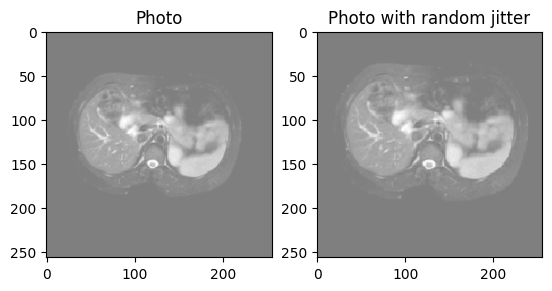

In [22]:
# a samples of monet and photo to display for showcasing the training efficiency
sample_mr = next(iter(train_mr))
sample_ct = next(iter(train_ct))

plt.subplot(121)
plt.title('Photo')
plt.imshow(sample_mr[0] * 0.5 + 0.5)
plt.subplot(122)
plt.title('Photo with random jitter')
plt.imshow(random_jitter(sample_mr[0]) * 0.5 + 0.5)

In [ ]:
# Loop to train the GAN
Loss = []
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_mr, train_ct)):
    gen_g_loss, gen_f_loss , disc_x_loss, disc_y_loss ,identity_loss_y, identity_loss_x, total_cycle_loss = train_step(image_x, image_y)
    Loss.append([gen_g_loss.numpy(), gen_f_loss.numpy(), disc_x_loss.numpy(), disc_y_loss.numpy(), identity_loss_y.numpy(), identity_loss_x.numpy(), total_cycle_loss.numpy()])    

    if n % 10 == 0:
      # used to show the progress
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_elephants) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_mr)

  # defining the interval to save checkpoints
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [ ]:
loss_array = np.array(Loss)
np.save(checkpoint_path + '/loss.npy', loss_array)

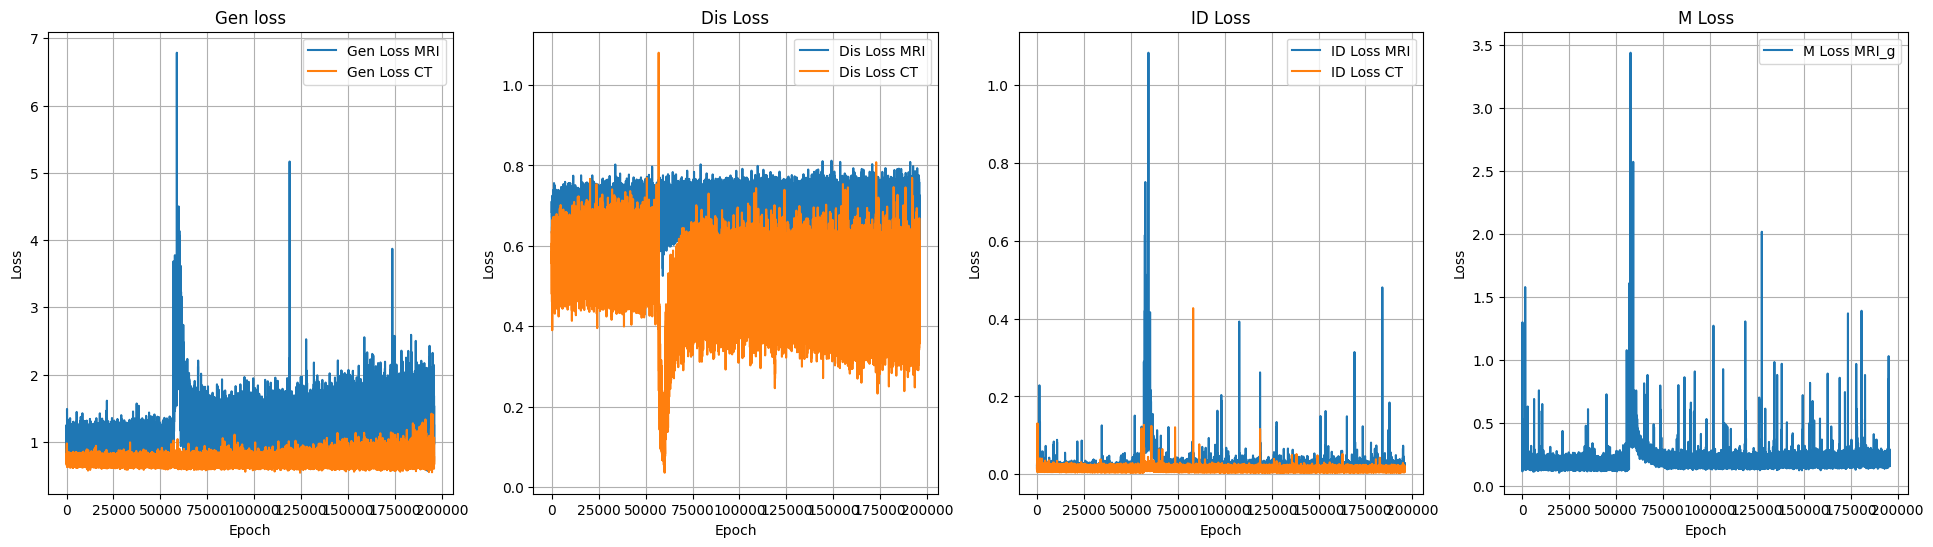

In [63]:
name = "/loss.npy_2024-08-13_03-33-37"
loss_array = np.load(checkpoint_path + name + '.npy')
loss1 = loss_array[:, 0]  # Assuming loss1 is the first column
loss2 = loss_array[:, 1]
loss3 = loss_array[:, 2]
loss4 = loss_array[:, 3]
loss5 = loss_array[:, 4]
loss6 = loss_array[:, 5]
loss7 = loss_array[:, 6]
epochs = range(len(loss1))

plt.figure(figsize=(24, 6))
plt.subplot(1,4,1)
plt.plot(epochs, loss1, label='Gen Loss MRI')
plt.plot(epochs, loss2, label='Gen Loss CT')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Gen loss")
plt.legend()
plt.grid(True)
plt.subplot(1,4,2)
plt.plot(epochs, loss3, label='Dis Loss MRI')
plt.plot(epochs, loss4, label='Dis Loss CT')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Dis Loss')
plt.legend()
plt.grid(True)
plt.subplot(1,4,3)
plt.plot(epochs, loss5, label='ID Loss MRI')
plt.plot(epochs, loss6, label='ID Loss CT')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ID Loss')
plt.legend()
plt.grid(True)
plt.subplot(1,4,4)
plt.plot(epochs, loss7, label='M Loss MRI_g')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('M Loss')
plt.legend()
plt.grid(True)
plt.show()

2024-08-15 01:25:03.353524: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5..1.2284317].


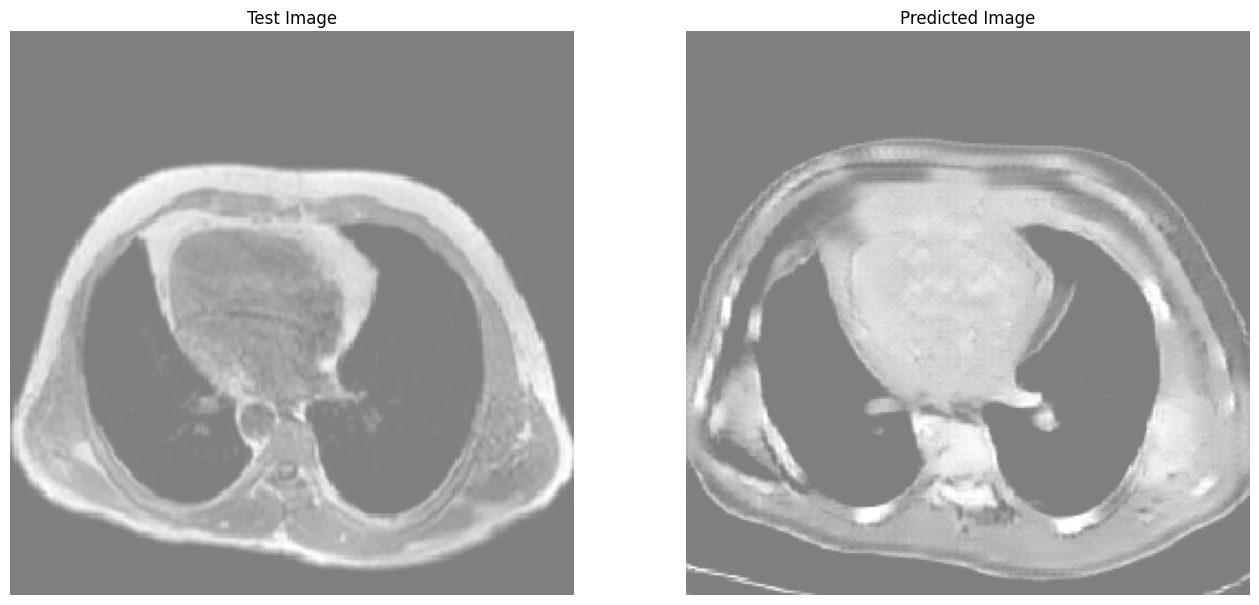

2024-08-15 01:25:10.056754: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5..1.215945].


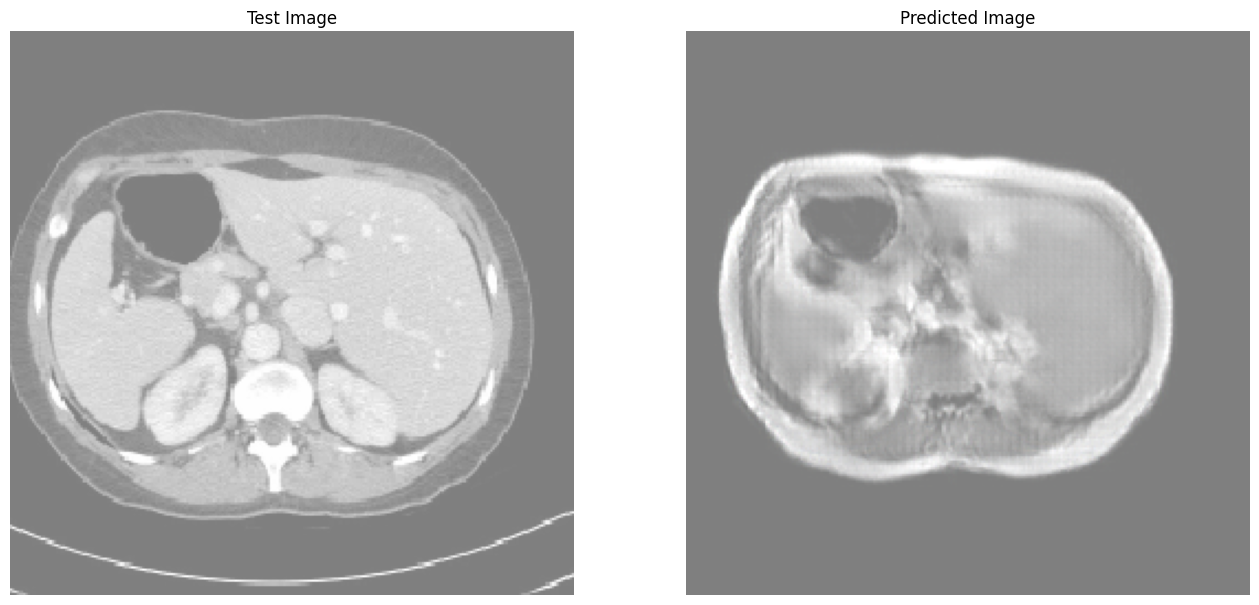

2024-08-15 01:25:15.173651: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [68]:
for inp in train_mr.take(1):
  generate_images(generator_g, inp)
for inp in train_ct.take(1):
  generate_images(generator_f, inp)